In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math
from sklearn.preprocessing import OneHotEncoder

pd.set_option('display.max_rows', 1000000)
pd.set_option('display.max_columns', 1000000)

In [4]:
df_demographics = pd.read_csv('dunnhumby-the-complete-journey/hh_demographic.csv')
df_demographics.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [6]:
df_transactions = pd.read_csv('dunnhumby-the-complete-journey/transaction_data.csv')
print('number of all transactions: ' +str(df_transactions.shape[0]))
df_transactions.head()

number of all transactions: 2595732


,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [7]:
transactions_with_demographic = df_transactions.merge(df_demographics, on='household_key', how='right')
print('number of transactions of people we have demographic info about: ' +str(transactions_with_demographic.shape[0]))


number of transactions of people we have demographic info about: 1427303


In [8]:
df_product = pd.read_csv('dunnhumby-the-complete-journey/product.csv')
gas_product_ids = df_product[df_product['SUB_COMMODITY_DESC'] == "GASOLINE-REG UNLEADED"]['PRODUCT_ID'].tolist()

fuel_transactions = transactions_with_demographic[transactions_with_demographic['PRODUCT_ID'].isin(gas_product_ids)]
print('number of transactions (only fuel) of people we have demographic info about: ' +str(fuel_transactions.shape[0]))

fuel_basket_ids = fuel_transactions['BASKET_ID'].unique()
print('number of baskets that have fuel in it: ' +str(fuel_transactions.shape[0]))


number of transactions (only fuel) of people we have demographic info about: 14772
number of baskets that have fuel in it: 14772


In [9]:
grocery_transactions = transactions_with_demographic[~(transactions_with_demographic['BASKET_ID'].isin(fuel_basket_ids))]
print('number of transactions (excluding fuel) of people we have demographic info about: ' +str(grocery_transactions.shape[0]))


number of transactions (excluding fuel) of people we have demographic info about: 1411931


In [13]:
big_big_transaction_table = grocery_transactions.merge(df_product, on='PRODUCT_ID', how='inner')
big_big_transaction_table.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,1364,26984896261,1,842930,1,2.19,31742,0.00,1520,1,0.0,0.0,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,69,GROCERY,Private,CONVENIENT BRKFST/WHLSM SNACKS,GRANOLA BARS,10 OZ
1,304,27950201718,81,842930,1,1.67,333,-0.52,1242,12,0.0,0.0,25-34,U,50-74K,Unknown,2 Adults No Kids,2,None/Unknown,69,GROCERY,Private,CONVENIENT BRKFST/WHLSM SNACKS,GRANOLA BARS,10 OZ
2,575,34186568032,485,842930,1,1.67,433,-0.62,2123,70,0.0,0.0,35-44,U,50-74K,Unknown,Single Female,1,None/Unknown,69,GROCERY,Private,CONVENIENT BRKFST/WHLSM SNACKS,GRANOLA BARS,10 OZ
3,77,28023861855,87,842930,3,5.00,346,-1.57,1844,13,0.0,0.0,35-44,A,100-124K,Homeowner,2 Adults Kids,5+,3+,69,GROCERY,Private,CONVENIENT BRKFST/WHLSM SNACKS,GRANOLA BARS,10 OZ
4,2317,27924836708,79,842930,2,3.33,372,-1.05,1326,12,0.0,0.0,35-44,A,50-74K,Homeowner,2 Adults Kids,5+,3+,69,GROCERY,Private,CONVENIENT BRKFST/WHLSM SNACKS,GRANOLA BARS,10 OZ


In [164]:
# Summing individual transactions to have total basket value
transactions_aggregated = big_big_transaction_table.groupby(["household_key","BASKET_ID",'STORE_ID', "DAY", "WEEK_NO","TRANS_TIME"])["SALES_VALUE"].sum().reset_index().sort_values(by='SALES_VALUE', ascending=False)
print('number of baskets: ' + str(transactions_aggregated.shape[0]))

# add demographic data
transactions_aggregated = transactions_aggregated.merge(df_demographics, on='household_key')

def get_hour(raw_time):
    if len(str(raw_time))<=2:
        return 0
    else:
        return str(raw_time)[:-2]

# fix time to show only the hour
transactions_aggregated['TRANS_TIME']=pd.to_numeric(transactions_aggregated['TRANS_TIME'].apply(get_hour))

transactions_aggregated.head()


number of baskets: 125574


,household_key,BASKET_ID,STORE_ID,DAY,WEEK_NO,TRANS_TIME,SALES_VALUE,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
0,1609,32006114302,412,339,49,20,961.49,45-54,A,125-149K,Homeowner,2 Adults Kids,5+,3+
1,1609,41366272382,412,641,92,12,315.31,45-54,A,125-149K,Homeowner,2 Adults Kids,5+,3+
2,1609,28867761574,412,147,22,11,256.87,45-54,A,125-149K,Homeowner,2 Adults Kids,5+,3+
3,1609,30971651243,412,266,39,12,251.87,45-54,A,125-149K,Homeowner,2 Adults Kids,5+,3+
4,1609,31969201029,412,336,49,11,238.11,45-54,A,125-149K,Homeowner,2 Adults Kids,5+,3+


In [165]:
non_numerical_columns = ['household_key','BASKET_ID','STORE_ID','AGE_DESC','MARITAL_STATUS_CODE','INCOME_DESC','HOMEOWNER_DESC','HH_COMP_DESC','HOUSEHOLD_SIZE_DESC','KID_CATEGORY_DESC']
categorical_columns = ['AGE_DESC','MARITAL_STATUS_CODE','INCOME_DESC','HOMEOWNER_DESC','HH_COMP_DESC','HOUSEHOLD_SIZE_DESC','KID_CATEGORY_DESC']

other_columns = list(filter(lambda x: x not in non_numerical_columns, transactions_aggregated.columns.tolist()))
                       
other_columns

['DAY', 'WEEK_NO', 'TRANS_TIME', 'SALES_VALUE']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a46059190>,
      dtype=object)

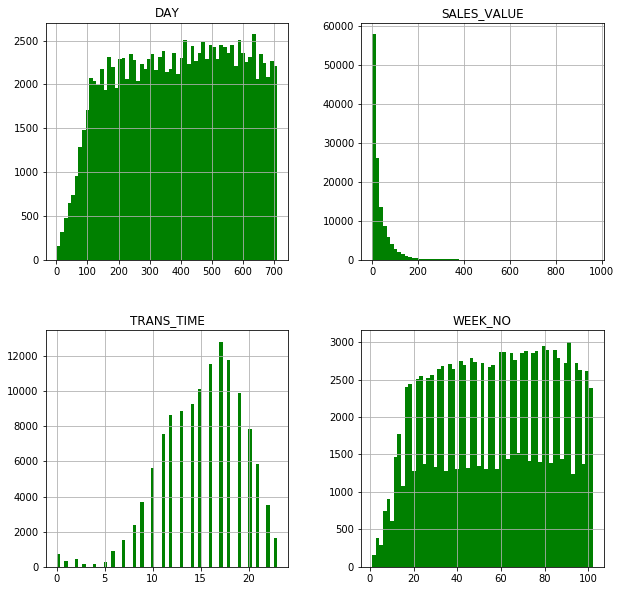

In [166]:
transactions_aggregated[other_columns].hist(bins=61, figsize=(10, 10), color='g')


In [167]:
for i,feat in enumerate(categorical_columns):
    print(transactions_aggregated[feat].value_counts())


45-54    46158
35-44    32252
25-34    20039
65+      10563
55-64     9068
19-24     7494
Name: AGE_DESC, dtype: int64
U    56576
A    51388
B    17610
Name: MARITAL_STATUS_CODE, dtype: int64
50-74K       28647
35-49K       26815
25-34K       13968
75-99K       12539
Under 15K    11471
15-24K       11188
125-149K      6567
100-124K      5495
150-174K      4213
250K+         2257
175-199K      1862
200-249K       552
Name: INCOME_DESC, dtype: int64
Homeowner          74892
Unknown            37955
Renter              8225
Probable Renter     2269
Probable Owner      2233
Name: HOMEOWNER_DESC, dtype: int64
2 Adults No Kids    38671
2 Adults Kids       29094
Single Female       22943
Single Male         14548
Unknown             12314
1 Adult Kids         8004
Name: HH_COMP_DESC, dtype: int64
2     48250
1     41594
3     18440
5+     9278
4      8012
Name: HOUSEHOLD_SIZE_DESC, dtype: int64
None/Unknown    87519
1               18225
3+              10036
2                9794
Name: KID_C

In [168]:
transactions_aggregated.head()

,household_key,BASKET_ID,STORE_ID,DAY,WEEK_NO,TRANS_TIME,SALES_VALUE,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
0,1609,32006114302,412,339,49,20,961.49,45-54,A,125-149K,Homeowner,2 Adults Kids,5+,3+
1,1609,41366272382,412,641,92,12,315.31,45-54,A,125-149K,Homeowner,2 Adults Kids,5+,3+
2,1609,28867761574,412,147,22,11,256.87,45-54,A,125-149K,Homeowner,2 Adults Kids,5+,3+
3,1609,30971651243,412,266,39,12,251.87,45-54,A,125-149K,Homeowner,2 Adults Kids,5+,3+
4,1609,31969201029,412,336,49,11,238.11,45-54,A,125-149K,Homeowner,2 Adults Kids,5+,3+


In [169]:
# treating sales with amount lower than 10 and higher than 400 dollars as outliers
transactions_aggregated_filtered = transactions_aggregated[(transactions_aggregated['SALES_VALUE']>=10)&
                                                           (transactions_aggregated['SALES_VALUE']<=400)]
transactions_aggregated_filtered = transactions_aggregated_filtered.sort_values(by='DAY').reset_index().drop('index', axis=1)
print(transactions_aggregated_filtered.shape)
transactions_aggregated_filtered.head()

(83674, 14)


,household_key,BASKET_ID,STORE_ID,DAY,WEEK_NO,TRANS_TIME,SALES_VALUE,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
0,718,26985360571,324,1,1,11,168.48,45-54,A,25-34K,Homeowner,2 Adults Kids,5+,3+
1,212,26985205886,288,1,1,13,69.26,35-44,U,Under 15K,Unknown,Single Female,1,None/Unknown
2,1172,26985025264,396,1,1,9,44.78,25-34,B,50-74K,Unknown,Single Male,1,None/Unknown
3,1060,26985040735,315,1,1,12,139.22,35-44,B,35-49K,Renter,2 Adults No Kids,2,None/Unknown
4,1364,26984896261,31742,1,1,15,11.37,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown


In [170]:
# add new columns where we have the amount the household spent on grocery shopping last time they shopped
# and another column which indicates how long it has been since the last time the hoseuhold shopped
transactions_aggregated_filtered['previous_amount'] = transactions_aggregated_filtered.groupby('household_key')['SALES_VALUE'].shift(1)

transactions_aggregated_filtered['last_shopping_day'] = transactions_aggregated_filtered.groupby('household_key')['DAY'].shift(1)
transactions_aggregated_filtered['days_since_last_shopping'] = transactions_aggregated_filtered['DAY']-transactions_aggregated_filtered['last_shopping_day']

transactions_aggregated_filtered['STORE_ID'] = transactions_aggregated_filtered['STORE_ID'].astype(str)


In [197]:
# a = transactions_aggregated_filtered.sort_values(by='SALES_VALUE').reset_index()
# a[a['SALES_VALUE']>50].head(500)

# # cutting from 10 dollar limit cuts out 42245 instances out

In [172]:
transactions_aggregated_filtered.head(20)

,household_key,BASKET_ID,STORE_ID,DAY,WEEK_NO,TRANS_TIME,SALES_VALUE,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,previous_amount,last_shopping_day,days_since_last_shopping
0,718,26985360571,324,1,1,11,168.48,45-54,A,25-34K,Homeowner,2 Adults Kids,5+,3+,NaN,NaN,NaN
1,212,26985205886,288,1,1,13,69.26,35-44,U,Under 15K,Unknown,Single Female,1,None/Unknown,NaN,NaN,NaN
2,1172,26985025264,396,1,1,9,44.78,25-34,B,50-74K,Unknown,Single Male,1,None/Unknown,NaN,NaN,NaN
3,1060,26985040735,315,1,1,12,139.22,35-44,B,35-49K,Renter,2 Adults No Kids,2,None/Unknown,NaN,NaN,NaN
4,1364,26984896261,31742,1,1,15,11.37,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,NaN,NaN,NaN
5,718,26997328096,324,2,1,19,45.40,45-54,A,25-34K,Homeowner,2 Adults Kids,5+,3+,168.48,1.0,1.0
6,304,27009301476,322,2,1,17,35.15,25-34,U,50-74K,Unknown,2 Adults No Kids,2,None/Unknown,NaN,NaN,NaN
7,2305,26996870743,414,2,1,13,93.79,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,NaN,NaN,NaN
8,2324,27008841762,32004,3,1,15,21.82,35-44,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,NaN,NaN,NaN
9,2324,27008841880,32004,3,1,15,41.26,35-44,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,21.82,3.0,0.0


In [367]:
training_data = transactions_aggregated_filtered.dropna()

X = training_data[['STORE_ID',
       'TRANS_TIME','AGE_DESC', 'MARITAL_STATUS_CODE',
       'INCOME_DESC', 'HOMEOWNER_DESC', 'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC',
       'KID_CATEGORY_DESC', 'previous_amount', 'days_since_last_shopping']]

# X = training_data[['STORE_ID',
#        'TRANS_TIME', 'previous_amount', 'days_since_last_shopping']]


y = training_data['SALES_VALUE']

In [368]:
X.dtypes

STORE_ID                     object
TRANS_TIME                    int64
AGE_DESC                     object
MARITAL_STATUS_CODE          object
INCOME_DESC                  object
HOMEOWNER_DESC               object
HH_COMP_DESC                 object
HOUSEHOLD_SIZE_DESC          object
KID_CATEGORY_DESC            object
previous_amount             float64
days_since_last_shopping    float64
dtype: object

In [369]:
X.shape

(82873, 11)

In [370]:
X.isna().sum()

STORE_ID                    0
TRANS_TIME                  0
AGE_DESC                    0
MARITAL_STATUS_CODE         0
INCOME_DESC                 0
HOMEOWNER_DESC              0
HH_COMP_DESC                0
HOUSEHOLD_SIZE_DESC         0
KID_CATEGORY_DESC           0
previous_amount             0
days_since_last_shopping    0
dtype: int64

In [371]:
X.head()

,STORE_ID,TRANS_TIME,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,previous_amount,days_since_last_shopping
5,324,19,45-54,A,25-34K,Homeowner,2 Adults Kids,5+,3+,168.48,1.0
9,32004,15,35-44,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,21.82,0.0
12,315,23,35-44,B,35-49K,Renter,2 Adults No Kids,2,None/Unknown,139.22,2.0
13,322,18,25-34,U,50-74K,Unknown,2 Adults No Kids,2,None/Unknown,35.15,1.0
14,414,12,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,93.79,1.0


In [372]:
X.shape

(82873, 11)

In [373]:
X = pd.get_dummies(X)


In [374]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## Decision Tree

In [350]:
from sklearn import tree

In [351]:
clf = tree.DecisionTreeRegressor(min_impurity_decrease=0.6, max_depth=20)
clf = clf.fit(X_train, y_train)

In [352]:
predicted = clf.predict(X_test)

In [353]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

predicted = clf.predict(X_test)
mae = mean_absolute_error(y_test, predicted)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, predicted)
rmse = math.sqrt(mse)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))

r2 = r2_score(y_test, predicted) 
print('R2: ' + str(r2))

mean absolute error: 28.354447932838763
mean squared error: 1649.9031875432877
root mean squared error: 40.61900032673487
R2: 0.07429868257262873


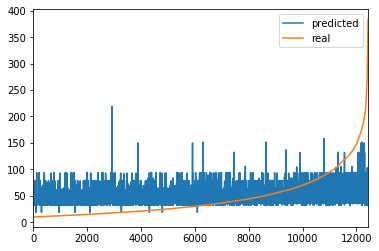

In [354]:
results = pd.DataFrame({'predicted':predicted, 'real':y_test}).sort_values(by=['real','predicted'])
results = results.reset_index().drop('index', axis=1)
results.plot()

In [355]:
results.head()

,predicted,real
0,31.802664,10.0
1,31.802664,10.0
2,31.802664,10.0
3,32.570294,10.0
4,34.631071,10.0


## Random Forest

In [356]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5,n_estimators=200)
regr.fit(X_train, y_train)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [357]:
print(X_train.shape)
print(X_test.shape)

(70442, 283)
(12431, 283)


In [358]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

predicted = regr.predict(X_test)
mae = mean_absolute_error(y_test, predicted)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, predicted)
rmse = math.sqrt(mse)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))

r2 = r2_score(y_test, predicted) 
print('R2: ' + str(r2))

mean absolute error: 28.397989782746166
mean squared error: 1643.401816939799
root mean squared error: 40.53889264570258
R2: 0.07794636770844232


In [359]:
results = pd.DataFrame({'predicted':predicted, 'real':y_test}).sort_values(by=['real','predicted'])
results = results.reset_index().drop('index', axis=1)

In [360]:
results.head(100)

,predicted,real
0,35.330686,10.00
1,35.530626,10.00
2,35.647890,10.00
3,36.538955,10.00
4,36.637798,10.00
5,37.134122,10.00
6,37.344847,10.00
7,37.459406,10.00
8,37.829877,10.00
9,37.944865,10.00


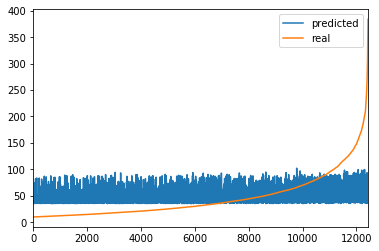

In [361]:
results.plot()

# XGBoost

In [375]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [376]:
param = {'max_depth':5, 'eta':0.7, 'booster':'gbtree', 'subsample':0.5,
         'objective':'reg:squarederror','eval_metric':'mae'}
bst = xgb.train(param, dtrain)

In [377]:
preds = bst.predict(dtest)

In [378]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mae = mean_absolute_error(y_test, preds)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, preds)
rmse = math.sqrt(mse)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))

r2 = r2_score(y_test, preds) 
print('R2: ' + str(r2))

mean absolute error: 27.058886145845747
mean squared error: 1505.6774655199265
root mean squared error: 38.803060002014355
R2: 0.1552185461694353


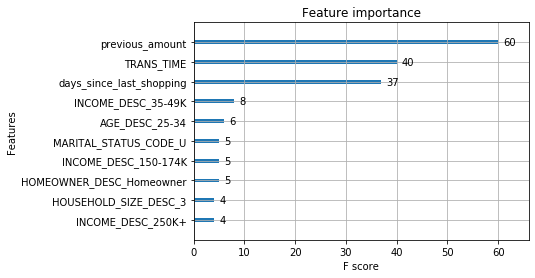

In [386]:
xgb.plot_importance(bst,max_num_features=10)

In [383]:
bst.get_score(importance_type='gain')

{'previous_amount': 64120.94728566666,
 'HOMEOWNER_DESC_Homeowner': 135666.53056704003,
 'days_since_last_shopping': 77759.04111451354,
 'HOMEOWNER_DESC_Probable Renter': 39700.5,
 'STORE_ID_359': 25014.5,
 'STORE_ID_446': 4542.67969,
 'STORE_ID_333': 29505.0,
 'HH_COMP_DESC_1 Adult Kids': 22924.5,
 'INCOME_DESC_150-174K': 81949.69688,
 'HH_COMP_DESC_2 Adults Kids': 94850.38543333334,
 'INCOME_DESC_125-149K': 81403.6333,
 'MARITAL_STATUS_CODE_U': 57605.04454000001,
 'STORE_ID_388': 62832.238399999995,
 'AGE_DESC_25-34': 21739.372531666664,
 'STORE_ID_292': 91272.0545,
 'STORE_ID_360': 20211.38475,
 'STORE_ID_412': 80495.39063333334,
 'INCOME_DESC_35-49K': 39974.199824999996,
 'KID_CATEGORY_DESC_None/Unknown': 100920.0,
 'INCOME_DESC_250K+': 40156.815950000004,
 'AGE_DESC_65+': 54178.41795,
 'TRANS_TIME': 25166.489992050007,
 'STORE_ID_296': 22886.5156,
 'STORE_ID_443': 39814.49755,
 'STORE_ID_448': 29669.0059,
 'STORE_ID_406': 93035.40363333334,
 'STORE_ID_442': 20502.7188,
 'STORE_ID_

In [379]:
results = pd.DataFrame({'predicted':preds, 'real':y_test}).sort_values(by=['real','predicted'])
results = results.reset_index().drop('index', axis=1)
results.head(100)

,predicted,real
0,21.588654,10.00
1,22.604448,10.00
2,24.648153,10.00
3,26.896893,10.00
4,28.322950,10.00
5,30.029303,10.00
6,30.489864,10.00
7,30.661486,10.00
8,30.697882,10.00
9,32.945251,10.00


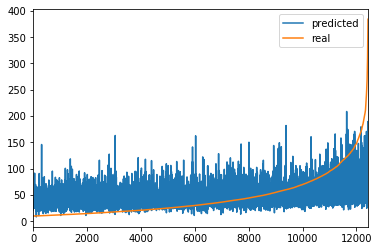

In [387]:
results.plot()

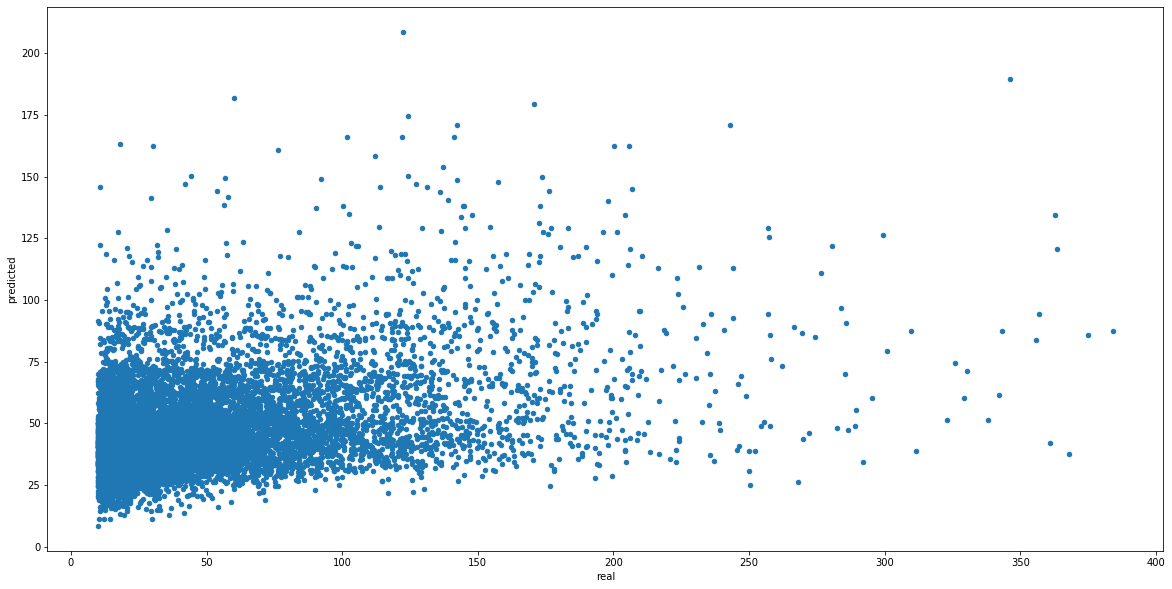

In [296]:
results.plot(kind='scatter',figsize=(20,10), x='real', y='predicted')

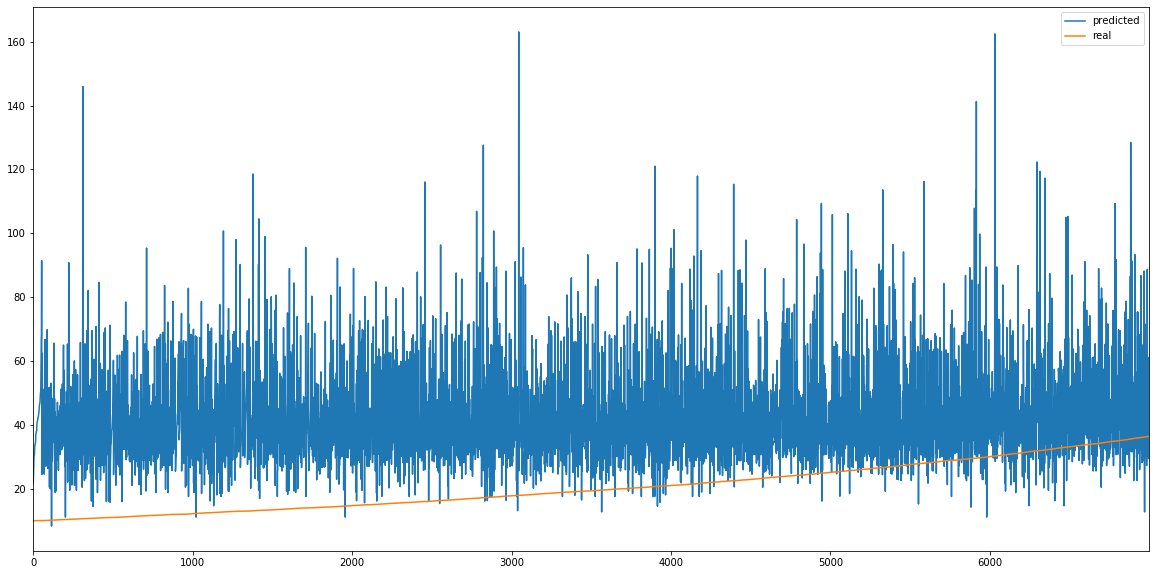

In [298]:
results.head(7000).plot(figsize=(20,10))

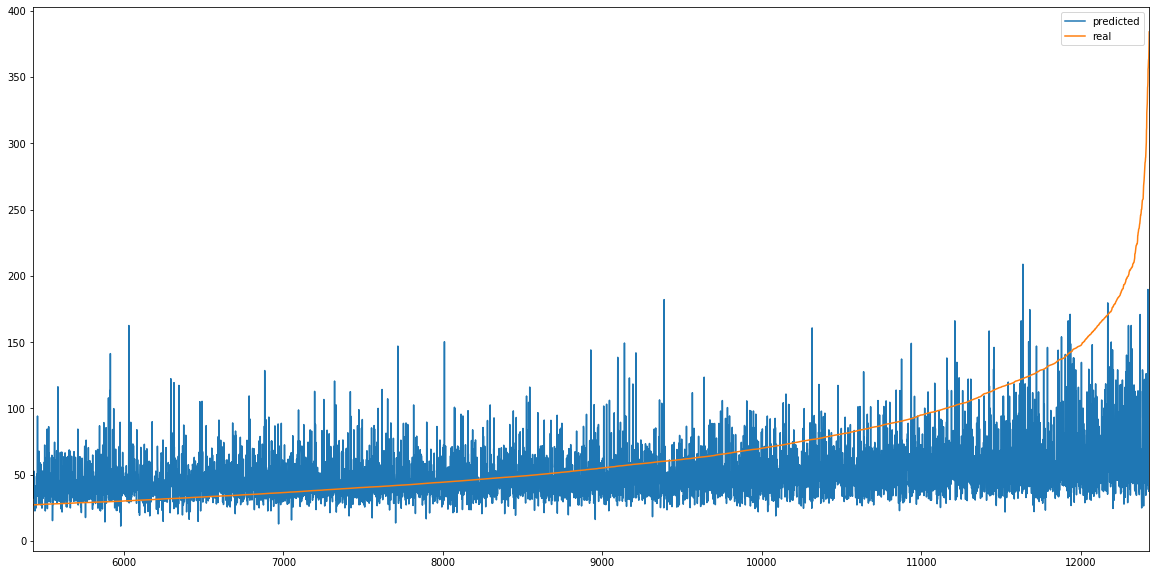

In [295]:
results.tail(7000).plot(figsize=(20,10))